In [2]:
from toolbar.average_filter import nanmean_filter
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter  # 专门提供经纬度的
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from matplotlib import gridspec
from matplotlib import ticker, colors
import cmaps
from matplotlib.ticker import MultipleLocator


from toolbar.masked import masked   # 气象工具函数


CN051_2 = xr.open_dataset(r"E:\data\CN05.1\2022\CN05.1_Tmax_2022_daily_025x025.nc")
zone_stations = masked((CN051_2 - CN051_2 + 1).sel(time='2022-01-01'), r"D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp").sum()['tmax'].data
Tmax_5Day_filt = xr.open_dataarray(fr"D:\PyFile\p2\data\Tmax_5Day_filt.nc")
T_th = 0.90
t95 = masked(Tmax_5Day_filt, r"D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp").quantile(T_th, dim=['year', 'day'])  # 夏季内 长江中下游流域 分位数
Tmax_5Day_filt_averTh = nanmean_filter(t95, 11)  # 11*11格点 空间滑动平均
EHD = Tmax_5Day_filt - 31.76166257
EHD = EHD.where(EHD > 0, 0)  # 极端高温日温度距平
EHD = EHD.where(EHD == 0, 1)  # 数据二值化处理(1:极端高温, 0:非极端高温)
EHD_0 = masked(EHD, r"D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp")  # 掩膜处理得长江流域EHD温度距平

D:\Anaconda\envs\PY312\Lib\site-packages\xarray\coding\times.py:213: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  ref_date = _ensure_padded_year(ref_date)
D:\Anaconda\envs\PY312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


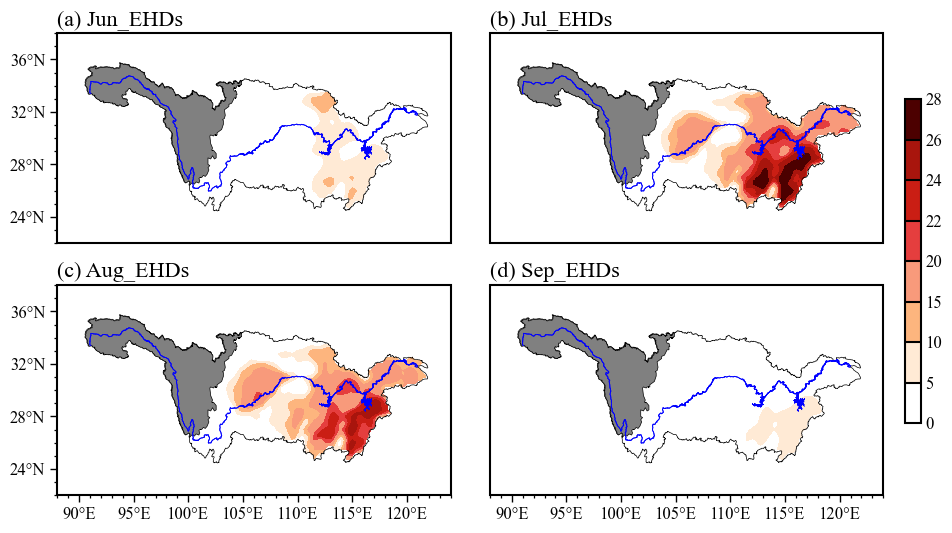

In [22]:
# 绘图
# ##地图要素设置
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False
spec = gridspec.GridSpec(ncols=2, nrows=2, wspace=0.1, hspace=0.2)  # 设置子图比例
extent_CN = [88, 124, 22, 38]  # 中国大陆经度范围，纬度范围
proj = ccrs.PlateCarree()   # 投影方式

#ax1
# 读取CN05.1逐日最高气温数据
EHD = EHD_0  # 读取缓存
EHD = EHD.sel(day=EHD['day'].isin([str(i) for i in range(0, 30)])).sum('day').mean('year')
# 将0值替换为缺测值
EHD = EHD.where(EHD > 0)
EHD = masked(EHD, r"D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp")
plt.rcParams['axes.edgecolor'] = 'black'
# 字体为新罗马
plt.rcParams['font.family'] = 'Times New Roman'

fig = plt.figure(figsize=(10.66, 6))   # 创建画布
ax1 = fig.add_subplot(spec[0, 0], projection=proj)  # 添加子图
# 统一加粗所有四个边框
for spine in ax1.spines.values():
    spine.set_linewidth(1.5)  # 设置边框线宽

ax1.set_extent(extent_CN, crs=proj) # 设置地图范围
ax1.set_aspect('auto')  # 设置长宽比
ax1.set_title('(a) Jun_EHDs', fontsize=16, loc='left')
level = [0, 5, 10, 15, 20, 22, 24, 26, 28]  # 等值线间隔
custom_colors = [
    "#FFFFFF",  # 原始
    "#FFEAD5",  # (5-10) 非常淡的蜜桃色
    "#FDB57E",  # (10-15) 柔和的橙色

    # --- 15以上：过渡柔和但区别清晰的红色系 ---
    "#F89A7B",  # (15-20) 柔和的珊瑚红/赤陶色作为过渡

    # --- 15以上：过渡柔和但区别清晰的红色系 ---
    "#E53E3E",  # (20-22) 纯正的红色
    "#CA1E14",  # (22-24) 开始变深的红色
    "#A8150D",  # (24-26) 暗红色
    "#4C0000"   # (28-30) 极深的暗红色，接近黑色，突出极值
            ]
custom_cmap = colors.ListedColormap(custom_colors)
from matplotlib.colors import BoundaryNorm
norm = BoundaryNorm(level, custom_cmap.N)

a1 = ax1.contourf(EHD['lon'], EHD['lat'], EHD.data, cmap=custom_cmap, levels=level, extend='max', transform=proj, norm=norm)
# ax1.add_feature(cfeature.LAND.with_scale('10m'),color='lightgray')# 添加陆地并且陆地部分全部填充成浅灰色
ax1.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp').geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=.5)
ax1.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\青藏高原边界数据总集\TPBoundary2500m_长江流域\TPBoundary2500m_长江流域.shp').geometries(), ccrs.PlateCarree(), facecolor='gray', edgecolor='black', linewidth=.5)
ax1.add_geometries(Reader(r'D:\PyFile\map\地图线路数据\长江\长江.shp').geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='blue', linewidth=0.6)
ax1.add_geometries(Reader(r'D:\PyFile\map\地图线路数据\长江干流_lake\lake_wsg84.shp').geometries(), ccrs.PlateCarree(), facecolor='blue', edgecolor='blue', linewidth=0.2)
#ax1.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False, linewidth=.1)


# 刻度线设置
xticks1=np.arange(extent_CN[0], extent_CN[1]+1, 10)
yticks1=np.arange(extent_CN[2], extent_CN[3]+1, 10)
'''ax1.set_xticks(xticks1, crs=proj)'''
ax1.set_yticks(yticks1, crs=proj)
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
'''ax1.xaxis.set_major_formatter(lon_formatter)'''
ax1.yaxis.set_major_formatter(lat_formatter)
'''xmajorLocator = MultipleLocator(5)#先定义xmajorLocator，再进行调用
ax1.xaxis.set_major_locator(xmajorLocator)#x轴最大刻度
xminorLocator = MultipleLocator(1)
ax1.xaxis.set_minor_locator(xminorLocator)#x轴最小刻度'''
ymajorLocator = MultipleLocator(4)
ax1.yaxis.set_major_locator(ymajorLocator)#y轴最大刻度
yminorLocator = MultipleLocator(1)
ax1.yaxis.set_minor_locator(yminorLocator)#y轴最小刻度
# 调整刻度值字体大小
ax1.tick_params(axis='both', labelsize=12, colors='black')
# 最大刻度、最小刻度的刻度线长短，粗细设置
ax1.tick_params(which='major', length=5, width=1, color='black')  # 最大刻度长度，宽度设置，
ax1.tick_params(which='minor', length=2, width=.9, color='black')  # 最小刻度长度，宽度设置
ax1.tick_params(which='both', bottom=True, top=False, left=True, labelbottom=True, labeltop=False)
ax1.grid(False)


# ax2
# 读取CN05.1逐日最高气温数据
EHD = EHD_0  # 读取缓存
EHD = EHD.sel(day=EHD['day'].isin([str(i) for i in range(30, 61)])).sum('day').mean('year')
# 将0值替换为缺测值
EHD = EHD.where(EHD > 0)
EHD = masked(EHD, r"D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp")

ax2 = fig.add_subplot(spec[0, 1], projection=proj)  # 添加子图
# 统一加粗所有四个边框
for spine in ax2.spines.values():
    spine.set_linewidth(1.5)  # 设置边框线宽

ax2.set_extent(extent_CN, crs=proj) # 设置地图范围
ax2.set_aspect('auto')  # 设置长宽比
ax2.set_title('(b) Jul_EHDs', fontsize=16, loc='left')

a2 = ax2.contourf(EHD['lon'], EHD['lat'], EHD.data, cmap=custom_cmap, levels=level, extend='max', transform=proj, norm=norm)
# ax1.add_feature(cfeature.LAND.with_scale('10m'),color='lightgray')# 添加陆地并且陆地部分全部填充成浅灰色
ax2.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp').geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=.5)
ax2.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\青藏高原边界数据总集\TPBoundary2500m_长江流域\TPBoundary2500m_长江流域.shp').geometries(), ccrs.PlateCarree(), facecolor='gray', edgecolor='black', linewidth=.5)
ax2.add_geometries(Reader(r'D:\PyFile\map\地图线路数据\长江\长江.shp').geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='blue', linewidth=0.6)
ax2.add_geometries(Reader(r'D:\PyFile\map\地图线路数据\长江干流_lake\lake_wsg84.shp').geometries(), ccrs.PlateCarree(), facecolor='blue', edgecolor='blue', linewidth=0.2)
#ax2.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False, linewidth=.1)

# 刻度线设置
xticks1=np.arange(extent_CN[0], extent_CN[1]+1, 10)
yticks1=np.arange(extent_CN[2], extent_CN[3]+1, 10)
'''ax2.set_xticks(xticks1, crs=proj)'''
# ax2.set_yticks(yticks1, crs=proj)
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
'''ax2.xaxis.set_major_formatter(lon_formatter)'''
ax2.yaxis.set_major_formatter(lat_formatter)
'''xmajorLocator = MultipleLocator(5)#先定义xmajorLocator，再进行调用
ax2.xaxis.set_major_locator(xmajorLocator)#x轴最大刻度
xminorLocator = MultipleLocator(1)
ax2.xaxis.set_minor_locator(xminorLocator)#x轴最小刻度'''
ymajorLocator = MultipleLocator(4)
ax2.yaxis.set_major_locator(ymajorLocator)#y轴最大刻度
yminorLocator = MultipleLocator(1)
ax2.yaxis.set_minor_locator(yminorLocator)#y轴最小刻度
# 调整刻度值字体大小
ax2.tick_params(axis='both', labelsize=12, colors='black')
# 最大刻度、最小刻度的刻度线长短，粗细设置
ax2.tick_params(which='major', length=5, width=1, color='black')  # 最大刻度长度，宽度设置，
ax2.tick_params(which='minor', length=2, width=.9, color='black')  # 最小刻度长度，宽度设置
ax2.tick_params(which='both', bottom=True, top=False, left=True, labelbottom=True, labeltop=False)
ax2.grid(False)


# ax3
# 读取CN05.1逐日最高气温数据
EHD = EHD_0  # 读取缓存
EHD = EHD.sel(day=EHD['day'].isin([str(i) for i in range(61, 92)])).sum('day').mean('year')
# 将0值替换为缺测值
EHD = EHD.where(EHD > 0)
EHD = masked(EHD, r"D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp")

ax3 = fig.add_subplot(spec[1, 0], projection=proj)  # 添加子图
# 统一加粗所有四个边框
for spine in ax3.spines.values():
    spine.set_linewidth(1.5)  # 设置边框线宽

ax3.set_extent(extent_CN, crs=proj) # 设置地图范围
ax3.set_aspect('auto')  # 设置长宽比
ax3.set_title('(c) Aug_EHDs', fontsize=16, loc='left')

a3 = ax3.contourf(EHD['lon'], EHD['lat'], EHD.data, cmap=custom_cmap, levels=level, extend='max', transform=proj, norm=norm)
# ax1.add_feature(cfeature.LAND.with_scale('10m'),color='lightgray')# 添加陆地并且陆地部分全部填充成浅灰色
ax3.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp').geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=.5)
ax3.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\青藏高原边界数据总集\TPBoundary2500m_长江流域\TPBoundary2500m_长江流域.shp').geometries(), ccrs.PlateCarree(), facecolor='gray', edgecolor='black', linewidth=.5)
ax3.add_geometries(Reader(r'D:\PyFile\map\地图线路数据\长江\长江.shp').geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='blue', linewidth=0.6)
ax3.add_geometries(Reader(r'D:\PyFile\map\地图线路数据\长江干流_lake\lake_wsg84.shp').geometries(), ccrs.PlateCarree(), facecolor='blue', edgecolor='blue', linewidth=0.2)

#ax3.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False, linewidth=.1)

# 刻度线设置
xticks1=np.arange(extent_CN[0], extent_CN[1]+1, 10)
yticks1=np.arange(extent_CN[2], extent_CN[3]+1, 10)
ax3.set_xticks(xticks1, crs=proj)
ax3.set_yticks(yticks1, crs=proj)
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax3.xaxis.set_major_formatter(lon_formatter)
ax3.yaxis.set_major_formatter(lat_formatter)
xmajorLocator = MultipleLocator(5)#先定义xmajorLocator，再进行调用
ax3.xaxis.set_major_locator(xmajorLocator)#x轴最大刻度
xminorLocator = MultipleLocator(1)
ax3.xaxis.set_minor_locator(xminorLocator)#x轴最小刻度
ymajorLocator = MultipleLocator(4)
ax3.yaxis.set_major_locator(ymajorLocator)#y轴最大刻度
yminorLocator = MultipleLocator(1)
ax3.yaxis.set_minor_locator(yminorLocator)#y轴最小刻度
# 调整刻度值字体大小
ax3.tick_params(axis='both', labelsize=12, colors='black')
# 最大刻度、最小刻度的刻度线长短，粗细设置
ax3.tick_params(which='major', length=5, width=1, color='black')  # 最大刻度长度，宽度设置，
ax3.tick_params(which='minor', length=2, width=.9, color='black')  # 最小刻度长度，宽度设置
ax3.tick_params(which='both', bottom=True, top=False, left=True, labelbottom=True, labeltop=False)
ax3.grid(False)


# ax4
# 读取CN05.1逐日最高气温数据
EHD = EHD_0  # 读取缓存
EHD = EHD.sel(day=EHD['day'].isin([str(i) for i in range(92, 122)])).sum('day').mean('year')
# 将0值替换为缺测值
EHD = EHD.where(EHD > 0)
EHD = masked(EHD, r"D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp")

ax4 = fig.add_subplot(spec[1, 1], projection=proj)  # 添加子图
# 统一加粗所有四个边框
for spine in ax4.spines.values():
    spine.set_linewidth(1.5)  # 设置边框线宽

ax4.set_aspect('auto')  # 设置长宽比
ax4.set_extent(extent_CN, crs=proj) # 设置地图范围
ax4.set_title('(d) Sep_EHDs', fontsize=16, loc='left')


a4 = ax4.contourf(EHD['lon'], EHD['lat'], EHD.data, cmap=custom_cmap, levels=level, extend='neither', transform=proj, norm=norm)
# ax1.add_feature(cfeature.LAND.with_scale('10m'),color='lightgray')# 添加陆地并且陆地部分全部填充成浅灰色
ax4.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\长江区1：25万界线数据集（2002年）\长江区.shp').geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=.5)
ax4.add_geometries(Reader(r'D:\PyFile\map\地图边界数据\青藏高原边界数据总集\TPBoundary2500m_长江流域\TPBoundary2500m_长江流域.shp').geometries(), ccrs.PlateCarree(), facecolor='gray', edgecolor='black', linewidth=.5)
ax4.add_geometries(Reader(r'D:\PyFile\map\地图线路数据\长江\长江.shp').geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='blue', linewidth=0.6)
ax4.add_geometries(Reader(r'D:\PyFile\map\地图线路数据\长江干流_lake\lake_wsg84.shp').geometries(), ccrs.PlateCarree(), facecolor='blue', edgecolor='blue', linewidth=0.2)

#ax4.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False, linewidth=.1)

# 刻度线设置
xticks1=np.arange(extent_CN[0], extent_CN[1]+1, 10)
yticks1=np.arange(extent_CN[2], extent_CN[3]+1, 10)
ax4.set_xticks(xticks1, crs=proj)
# ax4.set_yticks(yticks1, crs=proj)
lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
ax4.xaxis.set_major_formatter(lon_formatter)
ax4.yaxis.set_major_formatter(lat_formatter)
xmajorLocator = MultipleLocator(5)#先定义xmajorLocator，再进行调用
ax4.xaxis.set_major_locator(xmajorLocator)#x轴最大刻度
xminorLocator = MultipleLocator(1)
ax4.xaxis.set_minor_locator(xminorLocator)#x轴最小刻度
ymajorLocator = MultipleLocator(4)
ax4.yaxis.set_major_locator(ymajorLocator)#y轴最大刻度
yminorLocator = MultipleLocator(1)
ax4.yaxis.set_minor_locator(yminorLocator)#y轴最小刻度
# 调整刻度值字体大小
ax4.tick_params(axis='both', labelsize=12, colors='black')
# 最大刻度、最小刻度的刻度线长短，粗细设置
ax4.tick_params(which='major', length=5, width=1, color='black')  # 最大刻度长度，宽度设置，
ax4.tick_params(which='minor', length=2, width=.9, color='black')  # 最小刻度长度，宽度设置
ax4.tick_params(which='both', bottom=True, top=False, left=True, labelbottom=True, labeltop=False)
ax4.grid(False)


# color bar位置
# position = fig.add_axes([0.296, 0.08, 0.44, 0.011])#位置[x, y, w, h]
ax_cbar = fig.add_axes([0.92, 0.23, 0.015, 0.54])
cb4 = plt.colorbar(a4, orientation='vertical', cax=ax_cbar, aspect=30, shrink=.6, drawedges=True)#orientation为水平或垂直
cb4.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
cb4.outline.set_linewidth(1.5) # 在这里设置你想要的粗细，例如 2.5
cb4.dividers.set_color('black')  # 将colorbar内间隔线调为黑色
cb4.dividers.set_linewidth(1.5)
cb4.ax.tick_params(length=0, labelsize=12, color='black', direction='in')#length为刻度线的长度
tick_locator = ticker.FixedLocator([0, 5, 10, 15, 20, 25])  # colorbar上的刻度值个数

plt.savefig(r'D:\PyFile\p2\pic\图1.pdf', bbox_inches='tight')
plt.savefig(r'D:\PyFile\p2\pic\图1.png', dpi=600, bbox_inches='tight')
plt.show()